## Calculating Snow Depth and Ice Thickness Distributions

This notebook examines how to calculate snow depth and ice thickness distributions.  I use Mallet et al (2021) as the starting point.  In this paper, a probability distribution for snow depth anomalies is developed for snow on sea ice that can be used to estimate sub-grid scale snow depth distributions given a gridcell mean snow depth.

Snow depths measured along transects from Russian drifting stations are used to estimate the snow depth anomaly distribution and the relationship between mean snow depth and standard deviations of snow depths.

A linear relationship between mean snow depth $\bar{d}$ and standard deviation of snow depths $\sigma_d$ for each transect is estimated.  The best fit line is given by

$$
\sigma_{d} = 0.417 \times \bar{d}
$$

Snow depths are expressed as standardized anomalies.  Where standard anomaly snow depths $d'$ for each transect are given by:

$$
d' = \frac{d_i - \bar{d_i}}{\sigma_{d_i}}
$$

where $d_i$ is a snow depth measured along transect $i$. 

The distribution of standardized anomalies can be approximated by a skew-normal distribution with skewness $a = 2.54$, location $\xi = -1.11$ and scale $\omega = 1.5$  

In [5]:
import numpy as np
from scipy.stats import skewnorm

import matplotlib.pyplot as plt

The `scipy.stats.skewnorm` class can be used to define a continuous random variate for the Skew-norm distribution.

In [2]:
rv = skewnorm(a=2.54, loc=-1.11, scale=1.5)

Text(0, 0.5, 'Probability Density')

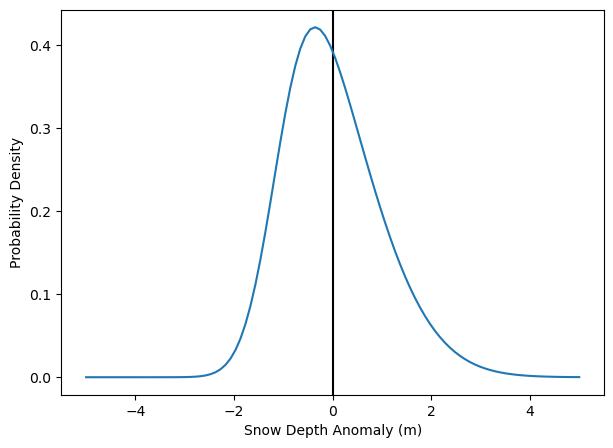

In [8]:
x = np.linspace(-5., 5., 100)
p = rv.pdf(x)

fig, ax = plt.subplots(figsize=(7,5))
ax.axvline(0., color='k', zorder=0)
ax.plot(x, p)
ax.set_xlabel('Snow Depth Anomaly (m)')
ax.set_ylabel('Probability Density')

Snow depth anomalies can be transformed into snow depths by multiplying by the standard deviation and adding the mean snow depth.  Where the standard deviation $\sigma_d$ is given by $0.417 \times \bar{d}$.

In [309]:
# Add plot showing distribution of snow depth

# Make join ice thickness and snow depth distributions using mapgrid

In [310]:
# Put these in script
def snow_depth_std(snow_depth_mean):
    """Returns standard deviation of snow depths"""
    cv = 0.417
    return cv * snow_depth_mean


def standardize_snow_depth(snow_depth, snow_depth_mean):
    """Returns standardized snow depths
    
    :snow_depth: snow depths in meters (array-like)
    :snow_depth_mean: mean snow depth (scalar)
    
    :returns: array of standardized snow depths
    """
    return (snow_depth - snow_depth_mean) / snow_depth_std(snow_depth_mean)


def snow_depth_anomaly_distribution():
    """Returns skewnorm distribution for snow depth anomalies from
    Mallet et al (2021).
    
    :returns: scipy rv_continuous class for skewnorm dist
    """
    skewness = 2.54
    location = -1.11
    scale = 1.5
    rv = skewnorm(skewness, location, scale)
    return rv


def get_bins(snow_depth_mean, nbins=7, factor=2., loc=None):
    edges = np.linspace(0., snow_depth_mean*factor, nbins+1)
    width = np.diff(edges)
    if loc == "lower":
        return edges[:-1], width
    elif loc == "upper":
        return edges[1:], width
    elif loc == "center":
        return (edges[:-1] + edges[1:])/2., width
    return edges, width


def snow_depth_distribution(snow_depth, nbins=7, factor = 3):
    """Returns a discrete snow depth distribution
    
    :snow_depth: mean snow depth
    :nbins: number of bins in distribution
    :factor: factor to set maximum snow depth as function of mean snow depth
    
    :returns: bin center depth, fraction of dsitribution in bin
    
    The .cdf() method is used instead of .pdf because this returns the cumulative
    probability (fraction below a bin edge).  Differencing this using np.diff
    returns the fraction of the disrete distribution in each bin.
    
    NB. If the maximum snow depth (set by factor) is too small, so that not all of
    the continuous distribution is covered by the discrete distribution, the sum
    fractions returned by snow_depth_anomaly_distribution.cdf() will not sum to 1.
    To solve this fraction is normalized by the sum of fraction.
    """
    
    edge, width = get_bins(snow_depth_mean, nbins=nbins, factor=factor)
    std_edge = standardize_snow_depth(edge, snow_depth_mean)

    prob = snow_depth_anomaly_distribution().cdf(std_edge)
    fraction = np.diff(prob)
    fraction = fraction/fraction.sum()  # normailize to 1
    
    center = (edge[1:] + edge[:-1]) / 2.
    
    return center, fraction

In [306]:
snow_depth_mean = 0.3
nbins = 7
factor = 3.
width = factor * snow_depth_mean / nbins
depth, prob = snow_depth_distribution(snow_depth_mean, nbins=nbins, factor=factor)
depth, prob, prob.sum()

(array([0.06428571, 0.19285714, 0.32142857, 0.45      , 0.57857143,
        0.70714286, 0.83571429]),
 array([0.06145821, 0.34041034, 0.36661567, 0.17168994, 0.0496422 ,
        0.00912   , 0.00106364]),
 0.9999999999999999)

The transformed snow depths are shown below for a mean snow depth 1.5 m.

<BarContainer object of 7 artists>

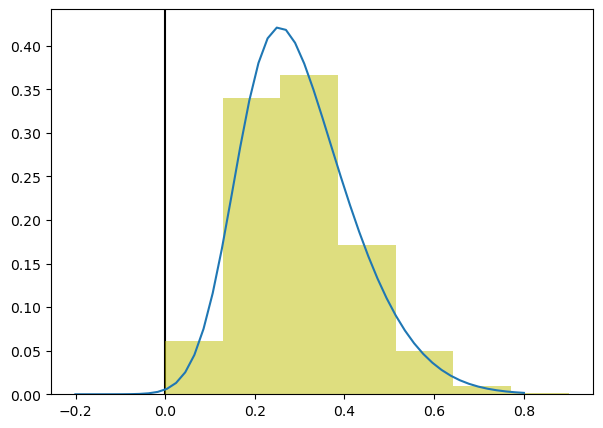

In [307]:
snow_depth_mean = 0.3

x = np.linspace(-4., 4., 50)
y = snow_depth_anomaly_distribution().pdf(x)

x = x * snow_depth_std(snow_depth_mean) + snow_depth_mean

fig, ax = plt.subplots(figsize=(7,5))
ax.axvline(0., color='k', zorder=0)

ax.plot(x, y)
ax.bar(depth, prob, width=width, color='y', alpha=0.5)

In [293]:
center, fraction = snow_depth_distribution(0.3)
print(center, fraction)

print(fraction.sum())


[0.21428571 0.64285714 1.07142857 1.5        1.92857143 2.35714286
 2.78571429] [0.06145821 0.34041034 0.36661567 0.17168994 0.0496422  0.00912
 0.00106364]
0.9999999999999999


In [213]:
lower = edges[:-1]
upper = edges[1:]
center = (lower + upper) / 2.

for i, (lo, ct, up) in enumerate(zip(lower, center, upper)):
    print(f"{i:2d} {lo:4.2f} {ct:4.2f} {up:4.2f}")

 0 0.00 0.06 0.13
 1 0.13 0.19 0.26
 2 0.26 0.32 0.39
 3 0.39 0.45 0.51
 4 0.51 0.58 0.64
 5 0.64 0.71 0.77
 6 0.77 0.84 0.90


The snow depth distribution is a continuous density function.  A discrete distribution is needed for modelling, so the distribution needs to be quantized into N equal-width bins over some interval.

For snow data, we decide on 7 bins for the interval 0 to $2 \bar{h}$.  In this example, the width of each bin is $\frac{2 \bar{h}}{7}$.

_NB.  The implicit assumption here is that if $\bar{h}$ is greater than zero, the gridcell, transect or area of interest, is always covered by some snow._.

The following function returns are set of bin centers.

In [58]:
hs_bin = bin_center(1.5)

The probability densities for the `bin_center` can be found by

In [59]:
hs_pdf = rv.pdf((bin_center(1.5) - 1.5) / snow_depth_std(1.5))

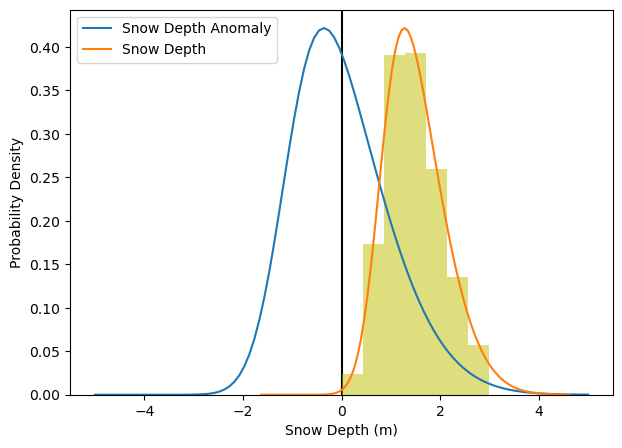

In [60]:
snow_depth_mean = 1.5
hs, p = snow_depth_distribution(snow_depth_mean)

fig, ax = plt.subplots(figsize=(7,5))
ax.axvline(0., color='k', zorder=0)
ax.plot(x, p, label='Snow Depth Anomaly')
ax.plot(hs, p, label='Snow Depth')
ax.bar(hs_bin, hs_pdf, width=(2*1.5/7), color='y', alpha=0.5)

ax.set_xlabel('Snow Depth (m)')
ax.set_ylabel('Probability Density')

ax.legend()

This looks fine.  The bars show the discretized probability densities fine.  However, when we check to see that these probability desnities sum to one, as we expect they should, we find they do not.

In [63]:
dw = 2. * 1.5 / 7

In [65]:
(hs_pdf * dw).sum()

0.613678457072652

In [49]:
(hs_pdf * (2/7)).sum()

0.40911897138176795

## Testing Robbies Code

From:

In [28]:
statistics = {'a': 2.542562886886376,
  'loc': -1.114525560819975,
  'scale': 1.4973819434202296,
  'CV': 0.41696167189340216,
             }

def get_std_from_mean(mean_depth, CV):
    std = mean_depth * CV
    return (std)

def depth_distribution_from_mean_depth_and_edges(mean_depth, dep_bin_edges, statistics):
    dep_bin_centres = dep_bin_edges[:-1] + (dep_bin_edges[1] - dep_bin_edges[0]) / 2

    std = get_std_from_mean(mean_depth, statistics['CV'])

    std_bin_edges = (dep_bin_edges - mean_depth) / std
    std_bin_centres = std_bin_edges[:-1] + (std_bin_edges[1] - std_bin_edges[0]) / 2
    std_bw = np.nanmean(np.diff(std_bin_edges))

    fit = skewnorm.pdf(std_bin_centres,
                       statistics['a'],
                       statistics['loc'],
                       statistics['scale']) * std_bw

    return (dep_bin_centres, fit)

def make_depth_dist(mean_depth,
                    n_bins = 10,
                    max_depth = 1.0):


    bin_edges = np.linspace(0,max_depth,n_bins+1)
    bin_width = np.diff(bin_edges)[0]

    bin_centres, probabilities = depth_distribution_from_mean_depth_and_edges(mean_depth,bin_edges,statistics)

    return (bin_centres, probabilities)


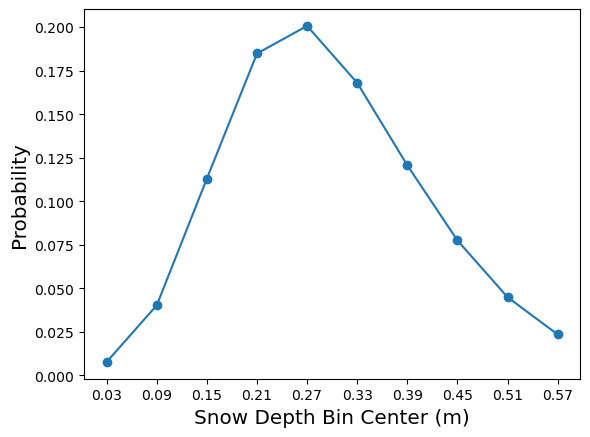

In [50]:
bin_centres, probabilities = make_depth_dist(mean_depth=0.3, max_depth=0.6)

# Code below plots the output

plt.plot(bin_centres,probabilities,marker='o')
plt.ylabel('Probability',fontsize='x-large')
plt.xlabel('Snow Depth Bin Center (m)',fontsize='x-large')
plt.xticks(bin_centres)
plt.show()


In [66]:
probabilities.sum()

0.9995026293912778

In [79]:
rv = skewnorm(a=2.54, loc=-1.11, scale=1.5)

In [80]:
x = np.linspace(-1., 1., 11)
dx = np.nanmean(np.diff(x))

In [81]:
p = rv.pdf(x)
(p * dx).sum()

0.7381704438110931

In [82]:
edge = np.linspace(0., 1., 11)
edge

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [83]:
center = edge[:-1] + (edge[1] - edge[0])/2.
center

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [85]:
std_center = (center - 0.3) / get_std_from_mean(0.3, 0.417)
std_center

array([-1.99840128, -1.19904077, -0.39968026,  0.39968026,  1.19904077,
        1.99840128,  2.79776179,  3.5971223 ,  4.39648281,  5.19584333])